> ## Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs), and What's In-Between

> Xử lý tiếng nói đóng một vai trò rất quan trọng, dù là trong các hệ thống ASR hay speaker recognition hay một hệ thống khác. MFCCs đã được sử dụng rất phổ biến trong một thời gian dài; nhưng hiện nay, filter banks đang trở nên phổ biến hơn. Trong notebook này, chúng ta sẽ thảo luận về filter banks và MFCCs và tại sao filter banks đang trở nên phổ biến hơn.

> Tính toán filter banks và MFCCs tuân theob một quy trình khá giống nhau, trong cả hai trường hợp, filter banks được tính toán và với một số bước nữa, ta thu được MFCCs. Tổng kết lại, một tín hiệu sẽ trải qua các bước sau:
>> 1. Đầu tiên, nó sẽ đi qua một pre-emphasis filter.
>> 2. Sau đó, signal sẽ được chia thành các frame có trùng lặp, đồng thời áp dụng window function lên mỗi frame.
>> 3. Tiếp theo, ta áp dụng Fourier transform trên mỗi frame (cụ thể là STFT) để tính được power spectrum của mỗi frame, và tính Filter Banks.
>> 4. Sau khi có Filter Banks, ta áp dụng DCT lên filter banks, giữ lại một số hệ số và loại bỏ các hệ số thừa, ta sẽ có được MFCCs.
>> 5. Bước cuối cùng là chuẩn hóa.

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
import os
tf.multiply(2,3)
clear_output()

### Setup

> Trong notebook này, tôi sử dụng 16-bit PCM wav file lấy từ [đây](http://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav), có sampling frequency là 8kHz. Wave file chúa tín hiệu tiếng nói gồm 1 giọng đọc một câu, có sự ngắt nghỉ giữa các câu. Để  cho đơn giản, chúng tôi sẽ sử dụng 3.5s đầu của tín hiệu, tương ứng với câu đầu tiên trong wave file.

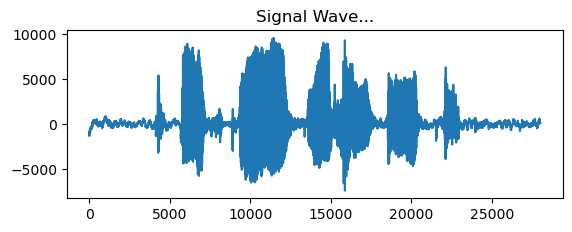

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fftpack import dct

# Read the wav file
sample_rate, signal = wav.read("OSR_us_000_0010_8k.wav")
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds 

# Plot the signal read from wav file in time domain
plt.subplot(2, 1, 1)
plt.title('Signal Wave...')
plt.plot(signal)
plt.show()

> Read with tensorflow.

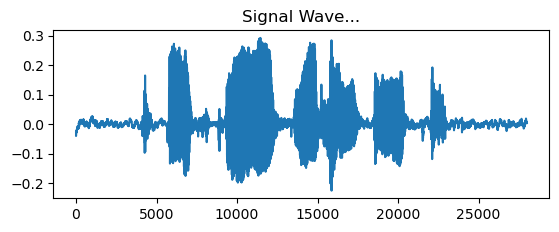

In [3]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

# Read the wav file
def get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform, sample_rate = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(waveform, axis=-1), sample_rate

waveform, sample_rate = get_waveform("OSR_us_000_0010_8k.wav")
# Keep the first 3.5 seconds
sample_rate = tf.cast(sample_rate, tf.float32)
waveform = waveform[:int(3.5 * sample_rate)]

# Plot the signal read from wav file in time domain, y axis is the amplitude, x axis is the time
plt.subplot(2, 1, 1)
plt.title('Signal Wave...')
plt.plot(waveform)
plt.show()

### Pre-Emphasis Filter

> Bước đầu tiên, chúng ta áp dụng pre-emphasis filter lên tín hiệu để khuếch đại tần số cao, pre-emphasis filter có một số tác dụng nổi bật như: Cân bằng phổ tần số vì tần số cao thường có cường độ nhỏ hơn so với tần số thấp; tránh các vấn đề về số học trong biến đổi Fourier và cải thiện tỉ số tín hiệu cực đại trên nhiễu - Signal to Noise Ratio (SNR). Pre-emphasis filter được áp dụng với tín hiệu $x(t)$ như sau:

>> $$y(t) = x(t) - \alpha x(t-1)$$

> Trong đó, $\alpha$ là một hằng số, thường được chọn là 0.95. Trong notebook này, tôi sử dụng $\alpha = 0.97$.

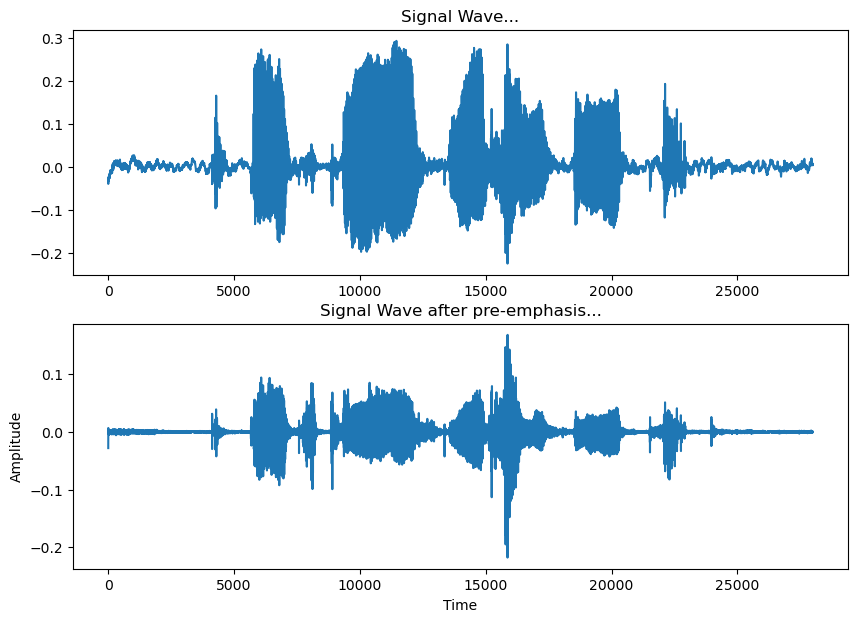

In [4]:
pre_emphasis_alpha = 0.97
emphasiszed_signal = np.append(waveform[0], waveform[1:] - pre_emphasis_alpha * waveform[:-1])

# Plot the signal and the signal after pre-emphasis
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.title('Signal Wave...')
plt.plot(waveform)
plt.subplot(2, 1, 2)
plt.title('Signal Wave after pre-emphasis...')
plt.plot(emphasiszed_signal)
# x tilte
plt.xlabel('Time')
# y tilte
plt.ylabel('Amplitude')
plt.show()

### Framing

> Sau pre-emphasis filter, chúng ta cần chia tín hiệu thành các frames ngắn. Lý do là tần số của tín hiệu liên tục thay đổi theo thời gian, do đó trong hầu hết các trường hợp việc áp dụng Fourier transform lên toàn bộ tín hiệu là vô nghĩa vì sẽ làm mất các đường tần số theo thời gian. Để xử lý vấn đề này, ta giả định tần số của tín hiệu là bất biến trong một khoảng thời gian ngắn. Vì vậy, khi áp dụng Fourier transform lên các short-time frame, chúng ta có thể thu được kết quả xấp xỉ tốt của tín hiệu bằng cách ghép các frames liền kề nhau lại.

> Thông thường, frame sizes thường nằm trong khoảng 20ms đến 40ms với 50% (+-10%) overlap giữa các frame. Trong notebook này, tôi sử dụng frame size là 25ms và overlap là 15ms (tức hop length = frame size - overlap = 10ms).

> Sử dụng tensorflow.

In [7]:
emphasiszed_signal.shape

(28000,)

In [6]:
# framing in tensorflow
frame_size = 0.025
frame_stride = 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
frame_length = tf.cast(frame_length, tf.int32)
frame_step = tf.cast(frame_step, tf.int32)

# Make a function to get frames
def get_frames(waveform, frame_length, frame_step):
    waveform_length = tf.shape(waveform)[0]
    num_frames = 1 + tf.cast(tf.floor((waveform_length - frame_length) / frame_step), tf.int32)
    pad_waveform_length = (num_frames - 1) * frame_step + frame_length
    if pad_waveform_length - waveform_length > 0:
        waveform = tf.pad(waveform, [[0, pad_waveform_length - waveform_length]])
    frames = tf.signal.frame(waveform, frame_length, frame_step, axis=0)
    return frames
get_frames(emphasiszed_signal, frame_length, frame_step).shape

TensorShape([348, 200])

> Sử dụng numpy.

In [ ]:
import numpy
emphasized_signal = emphasiszed_signal
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(tf.round(frame_length))
frame_step = int(tf.round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
frames.shape

> So sánh hai phương pháp.

In [ ]:
# print True if the two frames are the same
np.allclose(get_frames(emphasiszed_signal, frame_length, frame_step), frames)

In [ ]:
emphasiszed_signal = tf.cast(emphasiszed_signal, tf.float32)
stfts = tf.signal.stft(emphasiszed_signal, frame_length=frame_length, frame_step=frame_step)
# get the magnitude of the stfts
stfts = tf.abs(stfts)
stfts.shape

### Window

> Sau khi chia signal thành các frames, chúng tối áp dụng window function như: Hamming window lên mỗi frame để giảm thiểu hiện tượng biên cạnh (edge effect) và tăng độ chính xác của biến đổi Fourier, **giảm spectral leakage**. Window function được áp dụng với mỗi frame $x(t)$ như sau:
>> w[n] = 0.54 - 0.46 $cos(\frac{2\pi n}{N-1})$ <br>
> Trong đó, $w[n]$ là window function, $N$ là frame size và $n$ là chỉ số của mỗi sample trong frame. 0 $\leq$ n $\leq$ N-1.

> Dùng với numpy.

In [ ]:
frames1 = frames * np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **
frames1.shape

> Dùng với tensorflow.

In [ ]:
frames2 = frames * tf.signal.hamming_window(frame_length, periodic=True)
frames2.shape

In [ ]:
frames1

In [ ]:
frames2

### Fourier Transform and Power Spectrum

> Ta áp dụng N-point FFT lên mỗi frame để tính được power spectrum của frame đó. Power spectrum được tính như sau:

>> $$P(f) = \frac{1}{N} |X(f)|^2$$

> Trong đó, $X(f)$ là phổ tần số của frame đó, $N$ là frame size và $f$ là tần số.

In [ ]:
NFFT = 512
mag_frames1 = numpy.absolute(numpy.fft.rfft(frames1, NFFT))  # Magnitude of the FFT
pow_frames1 = ((1.0 / NFFT) * ((mag_frames1) ** 2))  # Power Spectrum
pow_frames1.shape

In [ ]:
# use tensorflow to calculate the power spectrum
NFFT = 512
mag_frames2 = tf.abs(tf.signal.rfft(frames2, [NFFT]))
pow_frames2 = (1.0 / NFFT) * tf.square(mag_frames2)
pow_frames2.shape

In [ ]:
pow_frames1

In [ ]:
pow_frames2

In [ ]:
# Calculate short time fourier transform
def get_stfts(waveform, frame_length, frame_step, fft_length=None):
    waveform = tf.cast(waveform, tf.float32)
    stfts = tf.signal.stft(waveform, frame_length, frame_step, fft_length, window_fn=tf.signal.hamming_window)
    stfts = tf.abs(stfts)
    return stfts

stfts = get_stfts(emphasiszed_signal, frame_length, frame_step, NFFT)
stfts == mag_frames2

In [ ]:
mag_frames2 = tf.abs(tf.signal.rfft(frames2, [NFFT]))
mag_frames2

In [ ]:
# compute power spectrum
pow_frames2 = (1.0 / NFFT) * tf.square(mag_frames2)
pow_frames2

### Filter Banks

> Bước cuối cùng trong việc tính filter banks là áp dụng bộ lọc tam giác (thường là 40 filters) trên Mel-scale (thang đo Mel) lên power spectrum của mỗi frame để tính được filter banks. **Mục đích của Mel-scale là mô phỏng đặc tính phi tuyến của tai người trong việc cảm thụ âm thanh - dễ dàng phân biệt các tần số thấp hơn so với các tần số cao hơn.** Ta chuyển Hertz (f) sang Mel (m) theo công thức sau:
>> $$m = 2595 \log_{10}(1 + \frac{f}{700})$$

> Trong đó, $f$ là tần số theo Hertz và $m$ là tần số theo Mel.

>> $$f = 700(10^{\frac{m}{2595}} - 1)$$

> Trong đó, $f$ là tần số theo Hertz và $m$ là tần số theo Mel.

> Mỗi filter trong filter bank là một xung tam giác có phản hồi là 1 ở trung tâm tần số và giảm tuyến tính về 0 khi nó đến vị trí tần số trung tâm của filter tiêps theo trong bank. Công thức tính filter bank là:
>> $$H_m(f) = \frac{1}{2} \left( 1 + \frac{f - f_{m-1}}{f_m - f_{m-1}} \right) \text{ if } f_{m-1} \leq f \leq f_m$$
>> $$H_m(f) = \frac{1}{2} \left( 1 - \frac{f - f_m}{f_{m+1} - f_m} \right) \text{ if } f_m \leq f \leq f_{m+1}$$
>> $$H_m(f) = 0 \text{ if } f \leq f_{m-1} \text{ or } f \geq f_{m+1}$$



In [ ]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames1, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
filter_banks.shape

In [ ]:
# plot spectrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.imshow(filter_banks.T, aspect='auto', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.title('Filter bank')
plt.tight_layout()
# x title
plt.xlabel('Time')
# y title
plt.ylabel('Frequency')
plt.show()

### Mel-Frequency Cepstral Coefficients (MFCCs)

> Các hệ số trong filter bank thường có mối tương quan cao với nhau. Để giảm thiểu mối tương quan này, ta áp dụng DCT (Discrete Cosine Transform) lên các hệ số trong filter bank sinh ra biểu diễn dạng nén của filter banks, gọi là MFCCs. Thông thường, trong ASR ta sẽ giữ lại 2-13 hệ số  MFCCs đầu tiên và loại bỏ các hệ số còn lại. Lý do là các hệ số sau biểu diễn sự thay đổi nhanh trong filter bank và không có ý nghĩa trong ASR.

In [ ]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]  # Keep 2-13
mfcc.shape

> Tiếp theo, ta có thể áp dụng sinusoidal liftering để giảm các MFCCs cao hơn. Sinusoidal liftering là một phương pháp giảm nhiễu trong MFCCs bằng cách nhân các MFCCs với một hàm sinusoidal. Sinusoidal liftering có thể được áp dụng như sau:
>> $$\text{MFCCs} = \text{MFCCs} \times sin(\frac{\pi}{2} \frac{m}{M})$$

> Trong đó, $m$ là chỉ số của MFCCs và $M$ là số lượng MFCCs.

In [ ]:
(nframes, ncoeff) = mfcc.shape
cep_lifter = 22
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

### Mean Normalization

> Để cân bằng spectrum và cải thiện Signal to Noise Ratio (SNR), ta có thể áp dụng mean normalization cho MFCCs. Mean normalization là một phương pháp chuẩn hóa dữ liệu bằng cách trừ đi giá trị trung bình của dữ liệu. Mean normalization có thể được áp dụng như sau:
>> $$\text{MFCCs} = \text{MFCCs} - \frac{1}{M} \sum_{m=1}^{M} \text{MFCCs}_m$$

> Trong đó, $m$ là chỉ số của MFCCs và $M$ là số lượng MFCCs.


In [ ]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

> Tương tự với MFCCs, ta có thể áp dụng mean normalization cho các hệ số trong filter bank. Tuy nhiên, mean normalization cho các hệ số trong filter bank thường không được áp dụng trong ASR.

In [ ]:
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

### Kết luận

> Sử dụng Mel-scaled filter banks nếu ML Algorithm không nhạy cảm với input có độ tương quan cao. Sử dụng MFCCs nếu ML Algorithm nhạy cảm với input có độ tương quan cao.